## 概要
<問題設定>
- 携帯電話の機能データからの価格帯分類

<前処理>
- 画面の縦幅と横幅という情報から画面の面積という特徴量を生成

<ハイパーパラメータのチューニング>
- 学習データが1200と少ないため、手作業でいくつかの値を試すのみ(本コードでは試した後の値を指定する/ベイズ最適化を試したが精度が落ちたためこの方法を採用)

<モデル>
- 単体での精度が高いブースティング系モデルを採用
- LightGBMでは過学習気味
- カテゴリ変数への扱いにたけ(target-encodingを採用)、様々な過学習対策をしているCatBoostを採用(本コードでカテゴリ変数は登場しないが、これまでの過程で取りうる値の種類が多いカテゴリ変数が登場していた)

<改善策>
- スタッキングを用いたアンサンブル学習を行う

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.stats import chi2_contingency
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, f1_score

### データの準備

In [29]:
train = pd.read_csv("data/train.csv", index_col=0) # 学習用データ
X_test = pd.read_csv("data/test.csv", index_col=0) # テスト用データ
submission = pd.read_csv("data/sample_submission.csv", index_col=0, header=None) # 応募用サンプルファイル

### EDA

In [30]:
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
id,,,,,,,,,,,,,,,,,,,,,
0,1203,0,0.680981,1,1,1,23,0.402580,117,3,...,1331,721,1970,15,1,4,1,0,1,2
3,1203,1,2.602754,1,0,0,8,0.415612,194,1,...,1571,1262,1150,14,16,14,1,0,1,3
4,1980,1,2.604065,1,0,0,6,0.858110,122,2,...,364,721,1970,18,12,11,1,0,1,1
5,1185,1,2.669403,1,3,0,33,0.027065,132,8,...,447,1162,1950,15,3,19,1,0,0,2
7,1203,1,2.375453,0,4,1,12,0.141485,135,6,...,364,1917,1970,16,7,6,1,1,1,0


In [31]:
X_test.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
id,,,,,,,,,,,,,,,,,,,,
1,1203,0,0.498993,1,0,1,40,0.914530,190,8,7,381,721,1970,6,1,2,1,0,1
2,1154,0,1.981014,0,1,0,33,0.025999,82,6,10,376,1555,1970,11,7,3,1,0,0
6,1027,1,1.647026,0,0,1,32,0.912318,103,6,1,364,1374,1970,17,1,6,1,0,0
10,833,0,1.070061,0,0,0,2,0.033010,156,7,0,1331,1710,832,12,8,8,1,1,0
12,1027,1,1.859165,0,4,1,2,0.612349,171,1,13,667,1642,2655,14,5,2,1,1,0


In [32]:
print(train.shape, X_test.shape)

(1200, 21) (800, 20)


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  1200 non-null   int64  
 1   blue           1200 non-null   int64  
 2   clock_speed    1200 non-null   float64
 3   dual_sim       1200 non-null   int64  
 4   fc             1200 non-null   int64  
 5   four_g         1200 non-null   int64  
 6   int_memory     1200 non-null   int64  
 7   m_dep          1200 non-null   float64
 8   mobile_wt      1200 non-null   int64  
 9   n_cores        1200 non-null   int64  
 10  pc             1200 non-null   int64  
 11  px_height      1200 non-null   int64  
 12  px_width       1200 non-null   int64  
 13  ram            1200 non-null   int64  
 14  sc_h           1200 non-null   int64  
 15  sc_w           1200 non-null   int64  
 16  talk_time      1200 non-null   int64  
 17  three_g        1200 non-null   int64  
 18  touch_sc

In [34]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 1998
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  800 non-null    int64  
 1   blue           800 non-null    int64  
 2   clock_speed    800 non-null    float64
 3   dual_sim       800 non-null    int64  
 4   fc             800 non-null    int64  
 5   four_g         800 non-null    int64  
 6   int_memory     800 non-null    int64  
 7   m_dep          800 non-null    float64
 8   mobile_wt      800 non-null    int64  
 9   n_cores        800 non-null    int64  
 10  pc             800 non-null    int64  
 11  px_height      800 non-null    int64  
 12  px_width       800 non-null    int64  
 13  ram            800 non-null    int64  
 14  sc_h           800 non-null    int64  
 15  sc_w           800 non-null    int64  
 16  talk_time      800 non-null    int64  
 17  three_g        800 non-null    int64  
 18  touch_scr

In [35]:
train['price_range'].value_counts()

2    420
1    300
3    268
0    212
Name: price_range, dtype: int64

In [36]:
# 統計量
train.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,1208.958333,0.408333,1.231201,0.565833,1.452500,0.625833,29.747500,0.374023,137.475833,3.815000,...,552.335000,1411.056667,1931.339167,11.970000,4.717500,10.376667,0.891667,0.410833,0.455000,1.620000
std,421.707099,0.491730,0.786728,0.495854,2.590045,0.484109,17.514071,0.322579,34.706169,2.455769,...,419.165889,467.548272,1157.539911,4.304595,3.346445,5.180942,0.310931,0.492190,0.498179,1.018069
min,518.000000,0.000000,0.466459,0.000000,0.000000,0.000000,2.000000,0.013852,80.000000,1.000000,...,4.000000,510.000000,267.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,916.000000,0.000000,0.498935,0.000000,0.000000,0.000000,15.000000,0.036577,105.000000,1.000000,...,272.000000,1011.000000,790.000000,7.000000,2.000000,7.000000,1.000000,0.000000,0.000000,1.000000
50%,1203.000000,0.000000,1.086733,1.000000,0.000000,1.000000,28.000000,0.351939,135.000000,3.000000,...,381.000000,1456.000000,1970.000000,12.000000,4.000000,9.000000,1.000000,0.000000,0.000000,2.000000
75%,1537.000000,1.000000,1.864943,1.000000,2.000000,1.000000,45.000000,0.798296,168.000000,6.000000,...,788.000000,1917.000000,3269.000000,16.000000,7.000000,14.000000,1.000000,1.000000,1.000000,2.000000
max,1991.000000,1.000000,2.730560,1.000000,16.000000,1.000000,64.000000,0.939585,199.000000,8.000000,...,1858.000000,1988.000000,3952.000000,19.000000,16.000000,20.000000,1.000000,1.000000,1.000000,3.000000


##### 気になった点

- fcは上に引っ張られてる(半分以上が0)

In [37]:
# 最もfcが高いデータ(外れ値の可能性あり)
train[train['fc'] == 16.000000]

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
id,,,,,,,,,,,,,,,,,,,,,
114,1271,0,0.498908,0,16,0,23,0.798624,136,7,...,497,1809,3269,18,8,2,0,0,1,3
160,1203,1,1.675705,0,16,0,15,0.029355,170,7,...,1092,1162,1503,16,3,19,0,0,0,1
281,1154,1,0.498926,0,16,1,32,0.415794,124,4,...,788,1119,3269,16,1,15,1,0,0,3
361,1843,0,2.499016,1,16,1,27,0.026249,132,4,...,1209,1957,1950,19,7,13,1,1,0,1
483,1154,1,0.478698,0,16,0,23,0.026881,155,1,...,22,997,2336,8,3,19,0,0,1,2
889,1537,0,2.672402,0,16,0,33,0.127067,101,4,...,193,1162,286,18,10,9,1,0,1,3
967,606,0,2.584703,0,16,0,33,0.130228,112,4,...,360,1162,286,18,7,9,1,1,1,1


In [38]:
# fcが0のデータの価格を見てみる
train[train['fc'] == 0.000000]['price_range'].value_counts()

2    310
1    159
3    145
0    123
Name: price_range, dtype: int64

##### 気付いた点
- fc(フロントカメラのメガピクセル)が大きくても、価格が高いとは限らない
- fcが0でも価格が高い商品が多い

-> fcはprice_rangeの推定に、そこまで重要ではないかも

In [39]:
# four_gとthree_gカラムは相関が強いのでは？

# クラメールの連関係数
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))) 

# 2つのカテゴリカル変数間のクロス集計表を作成
g_cross_tab = pd.crosstab(train['four_g'], train['three_g'])

# 相関を評価
correlation = cramers_v(train['four_g'], train['three_g'])
print("クラメールのV：", correlation)

g_cross_tab

クラメールのV： 0.41949951458491636


three_g,0,1
four_g,,
0,125,324
1,5,746


##### 気づいた点
- 弱~中程度の相関がある

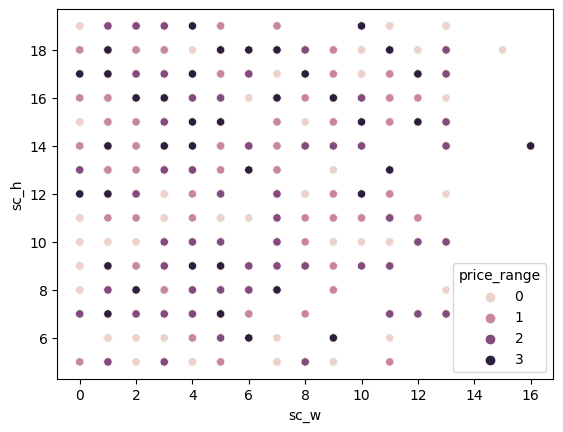

In [40]:
# 画面サイズが大きいほど高価なのでは？
sns.scatterplot(x='sc_w', y='sc_h', hue='price_range', data=train)
plt.show()

##### 気づいた点
- 横幅が広くて縦幅が狭い場合、低価格になりやすい
- サイズと価格で相関はほとんどなさそう

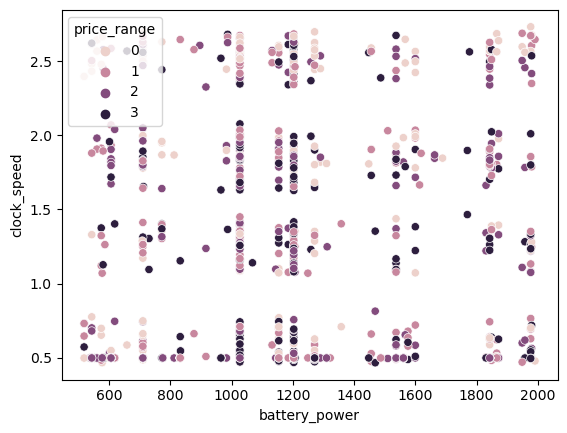

In [41]:
# 様々な値を取りそうなデータの散布図を表示
sns.scatterplot(x='battery_power', y='clock_speed', hue='price_range', data=train)
plt.show()

### 特徴量エンジニアリング

In [42]:
# 画面領域とピクセル解像度の領域という特徴量を作成
train['sc_hw'] = train['sc_h'] * train['sc_w']
train['px_hw'] = train['px_height'] * train['px_width']
X_test['sc_hw'] = X_test['sc_h'] * X_test['sc_w']
X_test['px_hw'] = X_test['px_height'] * X_test['px_width']

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  1200 non-null   int64  
 1   blue           1200 non-null   int64  
 2   clock_speed    1200 non-null   float64
 3   dual_sim       1200 non-null   int64  
 4   fc             1200 non-null   int64  
 5   four_g         1200 non-null   int64  
 6   int_memory     1200 non-null   int64  
 7   m_dep          1200 non-null   float64
 8   mobile_wt      1200 non-null   int64  
 9   n_cores        1200 non-null   int64  
 10  pc             1200 non-null   int64  
 11  px_height      1200 non-null   int64  
 12  px_width       1200 non-null   int64  
 13  ram            1200 non-null   int64  
 14  sc_h           1200 non-null   int64  
 15  sc_w           1200 non-null   int64  
 16  talk_time      1200 non-null   int64  
 17  three_g        1200 non-null   int64  
 18  touch_sc

### モデリング

In [44]:
# 学習データを特徴量と正解データに分離
target = 'price_range'
X_train = train.drop(target, axis=1)
y_train = train[target]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [45]:
cat_cols = X_train.select_dtypes(exclude=np.number).columns.to_list()

In [46]:
cat_cols

[]

In [47]:
cbc = CatBoostClassifier(iterations=1000, learning_rate=0.01, cat_features=cat_cols)
eval_set = [(X_val, y_val)]

# 学習
cbc.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=True)

0:	learn: 1.3823560	test: 1.3822617	best: 1.3822617 (0)	total: 11.4ms	remaining: 11.4s
1:	learn: 1.3781677	test: 1.3776749	best: 1.3776749 (1)	total: 14.3ms	remaining: 7.13s
2:	learn: 1.3733078	test: 1.3726762	best: 1.3726762 (2)	total: 17.2ms	remaining: 5.73s
3:	learn: 1.3693145	test: 1.3688972	best: 1.3688972 (3)	total: 20.1ms	remaining: 4.99s
4:	learn: 1.3645675	test: 1.3639838	best: 1.3639838 (4)	total: 22.7ms	remaining: 4.52s
5:	learn: 1.3601739	test: 1.3592623	best: 1.3592623 (5)	total: 25.2ms	remaining: 4.17s
6:	learn: 1.3560784	test: 1.3551540	best: 1.3551540 (6)	total: 27.8ms	remaining: 3.95s
7:	learn: 1.3521707	test: 1.3512060	best: 1.3512060 (7)	total: 31.1ms	remaining: 3.85s
8:	learn: 1.3482706	test: 1.3475708	best: 1.3475708 (8)	total: 33.7ms	remaining: 3.71s
9:	learn: 1.3440746	test: 1.3432289	best: 1.3432289 (9)	total: 36.6ms	remaining: 3.63s
10:	learn: 1.3407504	test: 1.3396354	best: 1.3396354 (10)	total: 39.7ms	remaining: 3.57s
11:	learn: 1.3373416	test: 1.3362381	best

In [49]:
# テストデータに対するF1マクロを表示

y_pred = cbc.predict(X_val)
report = classification_report(y_val, y_pred)
print(report)

f1_macro = f1_score(y_val, y_pred, average='macro')
print('F1マクロ：', f1_macro)

              precision    recall  f1-score   support

           0       0.39      0.38      0.38        53
           1       0.37      0.60      0.46        85
           2       0.83      0.62      0.71       136
           3       0.42      0.33      0.37        86

    accuracy                           0.51       360
   macro avg       0.50      0.48      0.48       360
weighted avg       0.56      0.51      0.52       360

F1マクロ： 0.47932066762441483


In [50]:
# 予測と評価
y_pred = cbc.predict(X_test)
submission[1] = y_pred 
submission.to_csv('main_submit.csv', header=None)